In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch.nn import Linear, LeakyReLU, MSELoss, Sequential
from torch.optim import Adam

from kymatio import Scattering1D


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


> Calculate scattering coefficients.

In [71]:
# import packages
from kymatio import Scattering1D
import kymatio

import torch.nn as nn
import torch.optim
import torch
import torch.utils.data as utils

import time
import sys

import numpy as np


#=========================================================================================================
# load light curves
real_spec = np.load("../light_curve.npy")[:10,:]
print(real_spec.shape)

### change the amplitude
#real_spec = real_spec*2.

## mix two modes
#real_spec = (real_spec[:,:] + real_spec[::-1,:])/2.


#================================================================================================
# define wavelet scattering hyperparameters
J = 6
Q = 8
T = real_spec.shape[1]

# convert into torch variable
x = torch.from_numpy(real_spec[:,:T]).type(torch.FloatTensor)
print(x.shape)

# define wavelet scattering
scattering = Scattering1D(J, T, Q)

#================================================================================================
# perform wavelet scattering
Sx_all = scattering.forward(x)

# calculate invariate representation
Sx_all = torch.mean(Sx_all[:,:,:], dim=-1)

# normalize wrt to the first coefficient
for i in range(Sx_all.shape[0]):
    Sx_all[i,:] = Sx_all[i,:]/np.abs(Sx_all[i,0])
    
# take log to normalize the coefficient better
Sx_all = torch.log10(Sx_all[:,1:])
print(Sx_all.shape)

(10, 10000)
torch.Size([10, 10000])
torch.Size([10, 125])


In [70]:
Sx_all_1 = np.copy(Sx_all)

In [72]:
Sx_all = Sx_all.numpy()

[-2.7221994 -2.7377234 -2.713464  -2.7178664 -2.7038078 -2.7090394
 -2.6936011 -2.6759672 -2.658696  -2.6518593 -2.9499073 -2.9288685
 -2.9156125 -2.9271665 -2.8754013 -2.8590329 -2.8739493 -2.8470428
 -3.13428   -3.1298647 -3.116212  -3.0700986 -3.083958  -3.0234034
 -3.0019758 -2.944558  -3.237379  -3.2628503 -3.2575567 -3.2772336
 -3.2036939 -3.133112  -3.0528948 -3.241663  -3.1796772 -3.055138
 -2.8467207 -2.7059505 -3.8358703 -4.0480957 -4.4406686 -4.851612
 -3.8568606 -4.079885  -4.4295387 -4.884039  -3.889796  -4.0396075
 -4.407173  -4.8634195 -3.9227643 -4.0476913 -4.3976684 -4.807501
 -3.9710882 -4.0700326 -4.379238  -4.758786  -3.995598  -4.055801
 -4.383183  -4.787759  -4.0321674 -4.040735  -4.307648  -4.74159
 -4.0693946 -4.062569  -4.308372  -4.66592   -4.1268363 -4.0702386
 -4.279109  -4.6219387 -4.1684523 -4.0846677 -4.2666054 -4.6103964
 -4.415941  -4.585824  -4.9162564 -4.4461727 -4.589142  -4.8854094
 -4.464962  -4.5596523 -4.877385  -4.4752517 -4.5406423 -4.8575644
 

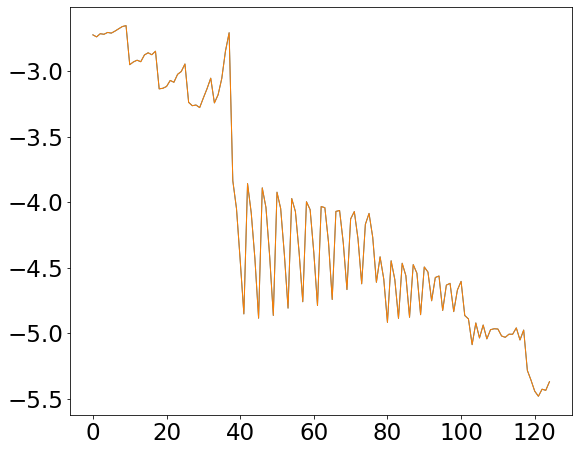

In [73]:
print(Sx_all_1[0,:])
plt.plot(Sx_all_1[0,:])
plt.plot(Sx_all[0,:])

> Check wavelet scattering coefficients.

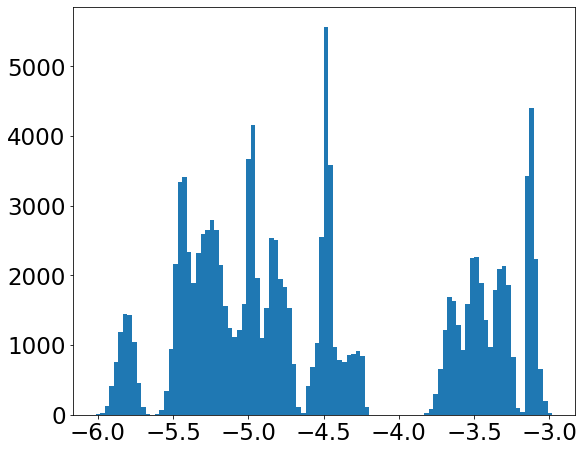

In [6]:
# load scattering coefficients
Sx = np.load("../Sx_all.npy")
plt.hist(Sx.ravel(), bins=100);

> Sample log probablity.

In [50]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# read scattering coefficents
y_tr = np.load("../Sx_all_x10.npy")

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_light_curve_x10.npz",\
         log_prob_x = log_prob_x)


Text(0, 0.5, '# light curves')

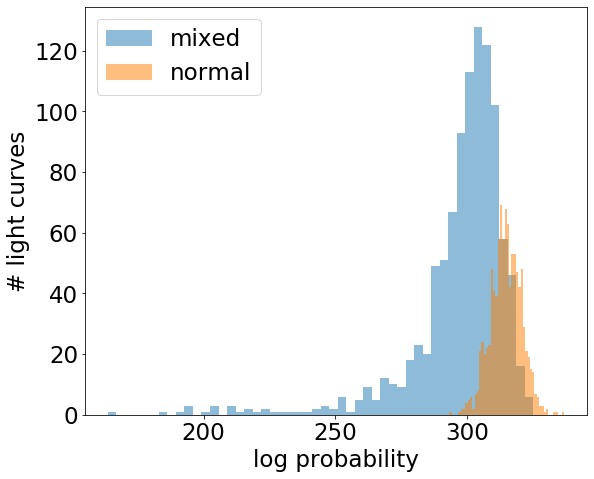

In [48]:
temp = np.load("../real_nvp_results_light_curve_x10.npz")
plt.hist(temp["log_prob_x"], bins=50, label="mixed", alpha=0.5);

temp = np.load("../real_nvp_results_light_curve_normal.npz")
plt.hist(temp["log_prob_x"], bins=50, label="normal", alpha=0.5);

plt.legend()

plt.xlabel("log probability")
plt.ylabel("# light curves")